<a href="https://colab.research.google.com/github/GaikwadSandesh/Deep_learning_projects/blob/main/Food_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

In [ ]:
! nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-08859a81-1a50-f052-c319-1fd3aff57780)


In [ ]:
# Hide warning logs (see: https://stackoverflow.com/a/38645250/7900723)
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Check TensorFlow version (should be 2.4.0+)
import tensorflow as tf
print(tf.__version__)

2.8.0


In [ ]:
# Get helper functions file
if not os.path.exists("helper_functions.py"):
    print("Downloading helper functions...")
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("Helper functions file already exists, skipping download...")


--2022-05-29 23:22:34--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-05-29 23:22:34 (130 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

In [ ]:
# download dataset

# download dataset

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
"food101" in tfds.list_builders()

True

In [ ]:
(train_data, test_data) , ds_info = tfds.load(name="food101", 
                                              split=["train", "validation"],
                                              shuffle_files = True ,
                                              as_supervised = True,
                                              with_info =True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteSP98BS/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteSP98BS/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
train_one_sample = train_data.take(1) 

In [ ]:
# What does one sample of our training data look like?
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:

# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 64
  Class name (str form): miso_soup
        


In [ ]:
# What are the min and max values?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

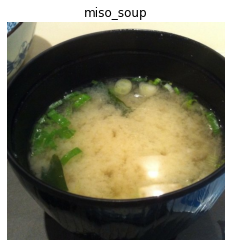

In [ ]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);


# create preprocessing functions
---



In [ ]:
def preprocess_img(image, label, img_shape = 224):
  image = tf.image.resize(image, [img_shape , img_shape])
  return tf.cast(image, tf.float32) , label

# Btch data

In [ ]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data , test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

# create callbacks

In [ ]:
 # Create TensorBoard callback (already have "create_tensorboard_callback()" from a previous notebook)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      montior="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=1) # don't print out whether or not model is being saved 

In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla P100-PCIE-16GB, compute capability 6.0
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla P100-PCIE-16GB, compute capability 6.0
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [ ]:
from numpy import dtype
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

input_shape = (224, 224 ,3 )
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

inputs = layers.Input(shape = input_shape, name= "input_layer")

x = base_model(inputs, training =False)
x = layers.GlobalAveragePooling2D(name = "pooling_layer")(x)
x = layers.Dense(len(class_names))(x)

outputs = layers.Activation("softmax" , dtype = tf.float32 , name = "softmax_float32")(x)
model = tf.keras.Model(inputs , outputs)

model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
model.fit(train_data,
          steps_per_epoch = len(train_data),
          batch_size = 32 ,
          epochs = 3 ,
          validation_data = test_data ,
          validation_steps = int(0.15*len(test_data)),
          callbacks = [create_tensorboard_callback("training_logs" , "efficientnetb0_101_classes_all_data_feature_extract") ,  
          model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20220530-000006
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.8210 - accuracy: 0.5594
Epoch 1: val_loss improved from inf to 1.22530, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 118s 42ms/step - loss: 1.8210 - accuracy: 0.5594 - val_loss: 1.2253 - val_accuracy: 0.6737
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.2927 - accuracy: 0.6671
Epoch 2: val_loss improved from 1.22530 to 1.12918, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 98s 41ms/step - loss: 1.2927 - accuracy: 0.6671 - val_loss: 1.1292 - val_accuracy: 0.6999
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.1439 - accuracy: 0.7029
Epoch 3: val_loss improved from 1.12918 to 1.09259, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/Deep Learning ZTM /Milestone 1/")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Deep Learning ZTM /Milestone 1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Deep Learning ZTM /Milestone 1/assets


# saved model

In [ ]:
# Load model previously saved above
loaded_saved_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/Deep Learning ZTM /Milestone 1/")

In [ ]:
loaded_saved_model.evaluate(test_data)

790/790 [==============================] - 30s 36ms/step - loss: 1.0885 - accuracy: 0.7053


[1.0885000228881836, 0.7052673101425171]

In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_saved_model.layers[1].layers[:20]: # check only the first 20 layers to save output space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 True float32 <Policy "float32">
rescaling_1 False float32 <Policy "mixed_float16">
normalization_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False 

# Fine tunning

In [ ]:
# Download the saved model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip 

--2022-05-30 00:17:15--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 172.253.117.128, 142.250.99.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16.19M  --.-KB/s    in 0.1s    

2022-05-30 00:17:15 (125 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]



In [ ]:
!mkdir downloaded_gs_model # create new dir to store downloaded feature extraction model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb  
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/assets/


In [ ]:
# Load and evaluate downloaded GS model
tf.get_logger().setLevel('INFO') # hide warning logs
loaded_gs_model = tf.keras.models.load_model("downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")

In [ ]:
# Get a summary of our downloaded model
loaded_gs_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# How does the loaded model perform?
results_loaded_gs_model = loaded_gs_model.evaluate(test_data)
results_loaded_gs_model

790/790 [==============================] - 30s 35ms/step - loss: 1.0881 - accuracy: 0.7067


[1.0880920886993408, 0.7066534757614136]

In [ ]:
# Are any of the layers in our model frozen?
for layer in loaded_gs_model.layers:
  layer.trainable = True # set all layers to trainable
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # make sure loaded model is using mixed precision dtype_policy ("mixed_float16")


input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


# callbacks

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3
)

checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint =tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_best_only = True ,
    monitor = "val_loss"
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = "val_loss",
    factor = 0.2 ,
    patience = 3 ,
    verbose = 1 ,
    min_lr = 1e-7
)

In [ ]:
# Compile the model
loaded_gs_model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [ ]:
from gc import callbacks
history_101_food_classes_all_data_fine_tune = loaded_gs_model.fit(
    train_data,
    epochs = 100 ,
    steps_per_epoch = len(train_data),
    validation_data = test_data,
    validation_steps = int(0.15 * len(test_data)),
    callbacks=[create_tensorboard_callback("training_logs", 
                                           "efficientb0_101_classes_all_data_fine_tuning"),
               model_checkpoint,
               early_stopping,
               reduce_lr]
)

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20220530-005442
Epoch 1/100
  34/2368 [..............................] - ETA: 6:31 - loss: 1.1267 - accuracy: 0.6985

KeyboardInterrupt: ignored